In [52]:
import pandas as pd
import numpy as np
import scipy
import copy
import matplotlib.pyplot as plt
import json
import statistics
from matplotlib.patches import Ellipse
from scipy.optimize import minimize
from scipy.stats import multivariate_normal
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from scipy.integrate import trapz
from functools import reduce
from tqdm import tqdm

In [2]:
# PARAMETERS
num_roles = 11
num_players = 14

'''Set a threshold value for the change in probability density functions'''
entropy_method_threshold = 1e-4 
# difference_method_threshold = 1e-3 

In [3]:
class CustomDataLoader:
    def __init__(self, file_path):
        self.file_path = file_path

    def load_data(self, team):
        """
        Loads soccer player position data from a CSV file and returns it as a numpy array.

        Returns:
            A numpy array with shape (num_frames, num_players, 2), where:
                - num_frames: The number of frames in the data file
                - num_players: The number of players (always 11 for soccer)
                - 2: The x and y coordinates of each player at each frame

        Raises:
            FileNotFoundError: If the file path provided does not exist

        """
        # Read the CSV file into a pandas DataFrame
        
        df = pd.read_csv(self.file_path)
        
        # Filter rows where Period equals 1
        df = df[df["Period"] == 1]

        # Extract the player position columns and reshape into a 3D array
        if team == "Home":
            player_cols = [f'Player{i}' for i in range(1, 15)]  # column names for player x positions
        else:
            player_cols = [f'Player{i}' for i in range(15, 29)]  
        num_frames = len(df)  # number of frames in the data
        num_players = 14  # total number of players, although only 11 can be on the field at once
        normalized_player_positions = np.zeros((num_frames, num_players, 2))  # 3D array to store player positions
        unnormalized_player_positions = np.zeros((num_frames, num_players, 2)) 
        unnormalized_ball_positions = np.zeros((num_frames, 2))  # 2D array to store player positions
                 
        # Loop through the frames and player columns
        for i, frame_group in enumerate(df.groupby('Frame')):
            frame_num, frame_data = frame_group
            
            # Extract the ball positions
            ball_x = frame_data['Ball-x'].values[0]
            ball_y = frame_data['Ball-y'].values[0]
            
            # If both x and y values are valid (i.e., not NaN), store them in the 3D array
            if not np.isnan(ball_x) and not np.isnan(ball_y):
                unnormalized_ball_positions[i, :] = [ball_x, ball_y]
            
            for j, player_col in enumerate(player_cols):
                # Get the x and y values for the current player and frame
                x_val = frame_data[player_col + '-x'].values[0]
                y_val = frame_data[player_col + '-y'].values[0]

                # If both x and y values are valid (i.e., not NaN), store them in the 3D array
                if not np.isnan(x_val) and not np.isnan(y_val):
                    normalized_player_positions[i, j, :] = [x_val, y_val]
                    unnormalized_player_positions[i, j, :] = [x_val, y_val]
                                       
        # Normalize player tracking data to have zero mean in each frame    
        '''we negate the effects of translation by normalizing the tracking 
        data to have zero mean in each frame'''
        for row in range(normalized_player_positions.shape[0]):
            mean_pos = sum(normalized_player_positions[row]) / 11       # Calculate mean position of all active players in this frame
            for coor in normalized_player_positions[row]:               # Subtract mean position from each player's position in this frame
                if (coor != 0).any(axis=0):
                    coor -= mean_pos         

            
        return normalized_player_positions, unnormalized_player_positions, unnormalized_ball_positions
    
    def load_data_interval(self, interval, player_positions):
        '''creates subsets of player_positions based on the interval value in minutes'''
       # Split the data into subsets of given interval
        num_rows = int(interval * 1500) # Number of rows for {interval} minutes of data
        num_subsets = len(player_positions) // num_rows # Number of subsets of {interval} minutes
        player_positions = player_positions[:num_subsets*num_rows]
        player_positions = player_positions.reshape(num_subsets, num_rows, 14, 2)
        
        return player_positions
    
    def expectation_maximization(self, player_positions, num_roles, num_players, entropy_method_threshold, norm=True):
        X = copy.deepcopy(player_positions)
        
        # Initialize the SoccerFormation
        formation = SoccerFormation(X, num_roles)

        # Compute means and covariances for each role before iterating through the data
        '''to be done before iterating through the data because it involves 
        computing the mean and covariance for each role based on the initial 
        role distribution, which is set outside the loop. These means and 
        covariances will be used to compute the log probabilities in the cost 
        matrix for each (x,y) position and each role label, which will be used 
        to assign role labels to the tracking data at each frame in the loop.'''
        template, cluster_covs = formation._initialize_template(X)

        # Initial compute of the probability density functions of each role.
        '''Create a multivariate normal distribution for each role with mean given by 
        the cluster center and covariance given by the covariance matrix of the cluster 
        for the corresponding player'''
        Pn_prev = []
        for n in range(num_roles):
            pdf = scipy.stats.multivariate_normal(mean=template[n, 0], cov=cluster_covs[n, 0])
            Pn_prev.append(pdf)

        # Plot the initial role distributions
        print('Initial Formation')
        formation.plot_clusters(template, cluster_covs)


        # Iterate EM algorithm until convergence
        iteration = 0
        while True:    
            iteration+=1
            # Define a dictionary to store the [x,y] coor pairs assigned to each of the 11 roles by the Hungarian algorithm
            data_for_new_pdfs = {'Role 1': [],
                                 'Role 2': [],
                                 'Role 3': [],
                                 'Role 4': [],
                                 'Role 5': [],
                                 'Role 6': [],
                                 'Role 7': [],
                                 'Role 8': [],
                                 'Role 9': [],
                                 'Role 10': [],
                                 'Role 11': [],
                                }    

            # Iterate through each frame of tracking data
            print('Iterating through the data set...')
            for row in range(X.shape[0]):
                # Initialize the count matrix
                role_labels = np.zeros((11, 11))

                # Extract only the non-zero x,y coordinate pairs
                nonzero_mask = np.any(X[row] != [0.0, 0.0], axis=1)  # We only want to select the data points for players != [0.0, 0.0]
                nonzero_X = X[row][nonzero_mask] 

                # Create a cost matrix based of the log probability of each (x,y) position being assigned a particular role label
                cost_matrix = np.zeros((11, 11))
                for role in range(num_roles): 
                    for player in range(11):
                        cost_matrix[role,player] = np.log(Pn_prev[role].pdf(nonzero_X[player])) 

                # Use the Hungarian algorithm to compute the optimal assignment
                '''The scipy implementation of the algorithm is based on the Munkres algorithm, 
                which is a specific version of the Hungarian algorithm.'''
                row_ind, col_ind = scipy.optimize.linear_sum_assignment(cost_matrix, maximize = True) # Expectation Maximization

                # Assign role labels to the tracking data and update the count matrix for each frame
                for i, j in zip(row_ind, col_ind):
                    role_labels[i, j] += 1

                '''Create a dictionary for all 11 roles. Based on the output of the role_lables matrix at each row, 
                append to the respective k, the coordinate pair of the player responsible for that role assignment. 
                I can recompute the mean/covariance later for each of the 11 roles by accessing the [x,y] pairs at each key'''
                for row in range(role_labels.shape[0]):
                    data_idx = np.where(role_labels[row] == 1)[0][0]
                    data_for_new_pdfs[f'Role {row+1}'].append(list(nonzero_X[data_idx]))

            '''Once role labels have been assigned to all
            frames of the tracking data, we recompute the probability
            density functions of each role.

            New mean vectors and covariance matrices are computed using the player 
            coordinate pairs assigned to each of the 11 roles by the Hungarian algorithm.

            New multivariate normal distributions for each role are next computed
            using the updated mean vectors and covariance matrices.'''

            # Compute new mean vectors and covariance matrices for each role
            new_templates = np.zeros((num_roles, 1, 2))
            new_cluster_covs = np.zeros((num_roles, 1, 2, 2))
            for role, matched_coords in data_for_new_pdfs.items():
                # Convert matched_coords to a NumPy array
                matched_coords = np.array(matched_coords)
                # Compute the centroid of the matched coordinates
                new_mean = matched_coords.mean(axis=0)
                # Compute the covariance matrix of the matched coordinates
                new_cov = np.cov(matched_coords, rowvar=False)
                # Create new multivariate normal distributions for each role
                new_templates[int(role[-2:]) - 1, 0, :] = new_mean
                new_cluster_covs[int(role[-2:]) - 1, 0, :, :] = new_cov

            # Recompute probability density functions for each role
            Pn_new = []
            for n in range(num_roles):
                pdf = scipy.stats.multivariate_normal(mean=new_templates[n, 0, :], cov=new_cluster_covs[n, 0, :, :])
                Pn_new.append(pdf)

        #     '''PDF Difference Convergence Criteria'''
        #     # compute change in probability density functions
        #     delta = []
        #     for n in range(num_roles):
        #         nonzero_mask = X[:, n, :].any(axis=1)
        #         nonzero_X = X[:, n, :][nonzero_mask] 
        #         delta.append(abs(Pn_new[n].logpdf(nonzero_X) - Pn_prev[n].logpdf(nonzero_X)))

        #     # find the set of indices that have valid delta values for all roles
        #     valid_indices = reduce(set.intersection, [set(np.where(np.isfinite(d))[0]) for d in delta])

        #     # calculate average delta using valid indices
        #     delta_avg = np.mean([d[i] for i in valid_indices for d in delta])

        #     # Plot the updated role distributions
        #     print(f'Iteration: {iteration} Delta: {delta_avg}')
        #     formation.plot_clusters(new_templates, new_cluster_covs)    

        #     # check for convergence
        #     if delta_avg < difference_method_threshold:
        #         break

            '''Entropy Difference Convergence Criteria'''
            # compute change in probability density function entropy
            entropies = []
            for n in range(num_roles):
                nonzero_mask = X[:, n, :].any(axis=1)
                nonzero_X = X[:, n, :][nonzero_mask] 
                entropy = scipy.stats.entropy(Pn_new[n].pdf(nonzero_X), Pn_prev[n].pdf(nonzero_X))
                '''The scipy.stats.entropy function takes two probability distributions 
                as input, and computes the Kullback-Leibler divergence from the second to 
                the first distribution. If the two distributions are identical, the result is 0. 
                The function returns the entropy value in nats (natural logarithmic units) by default'''
                entropies.append(entropy)

            # calculate average entropy
            entropy_avg = np.mean(entropies)

            # Plot the updated role distributions
            print(f'Iteration: {iteration} Delta: {entropy_avg}')
            formation.plot_clusters(new_templates, new_cluster_covs, norm=norm)  

            # check for convergence
            if entropy_avg < entropy_method_threshold:
                return data_for_new_pdfs, formation

            # update previous probability density functions
            Pn_prev = Pn_new.copy()

        


In [4]:
class SoccerFormation:
    def __init__(self, data, num_roles):
        self.data = data
        self.num_roles = num_roles
        self.template_formation = None
        
    def _initialize_template_formation(self, num_roles):
        # randomly assign players to roles for the template formation
        player_indices = np.arange(num_roles)
        np.random.shuffle(player_indices)
        role_indices = np.array_split(player_indices, self.num_roles)
        self.template_formation = np.zeros((self.num_roles, num_roles))
        for i, indices in enumerate(role_indices):
            self.template_formation[i, indices] = 1
            
    def _initialize_template(self, X):
        '''KMeans will likely result in a more representative and cohesive template formation 
        than the random assignment used in the previous implementation.
        
        Loop through the players and cluster their positions separately for a total of 11 clusters
        
        This results in a template of shape (11, 1, 2), with one cluster center per player.'''
        # Initialize an empty array for the template formation
        template = np.zeros((self.num_roles, 1, X.shape[2]))
        cluster_covs = np.zeros((self.num_roles, 1, X.shape[2], X.shape[2]))

        # Loop through each player and cluster their positions separately
        for player in range(self.num_roles):
            kmeans = KMeans(n_clusters=1)
            nonzero_mask = np.any(X[:, player, :] != [0.0, 0.0], axis=1)  # We only want to select the data points for players != [0.0, 0.0]
            nonzero_X = X[:, player, :][nonzero_mask]  
            kmeans.fit(nonzero_X) # This will select all rows from the first dimension, 
                                  # the positions for the current player from the second dimension, 
                                  # and both x and y coordinates from the third dimension.
            template[player] = kmeans.cluster_centers_
            
            # Compute the covariance matrix of the cluster
            labels = kmeans.predict(nonzero_X)
            cluster_covs[player] = np.cov(nonzero_X[labels == 0].T)

        return template, cluster_covs

    def plot_clusters(self, template, cluster_covs, template2=None, cluster_covs2=None, method=None, norm = True, individual_data=None):
        """
        Plots the soccer player positions along with their corresponding clusters as 2D Gaussians.

        Args:
            template: A numpy array of shape (11, 1, 2) containing the cluster centers for each player
            cluster_covs: A numpy array of shape (11, 1, 2, 2) containing the covariance matrices for each player's cluster

        """
        # Set up the figure
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.set_aspect('equal')

        # Plot the player positions as dots
        for i in range(template.shape[0]):
            x, y = template[i][0]

            # Get the cluster covariance matrix and mean
            cov = cluster_covs[i][0]
            mean = template[i][0]

            # Get the eigenvalues and eigenvectors of the covariance matrix
            eigenvalues, eigenvectors = np.linalg.eigh(cov)

 
            
            if method == 'adversarial':
                x2, y2 = template2[i][0]
                
                ax.plot(x2, y2, 'o', markersize=10, alpha=0.5, label=f'Player {i+1}', color='blue')
                ax.plot(x, y, 'o', markersize=10, alpha=0.5, label=f'Player {i+1}', color='red')

                cov2 = cluster_covs2[i][0]
                mean2 = template2[i][0]
                eigenvalues2, eigenvectors2 = np.linalg.eigh(cov2)
                
                #Plot AWAY ellipse
                ellipse2 = Ellipse(xy=mean2, width=2*np.sqrt(eigenvalues2[0]), height=2*np.sqrt(eigenvalues2[1]), 
                              angle=np.degrees(np.arctan2(*eigenvectors2[:, 0][::-1])), edgecolor='blue', lw=2, fill=False, alpha=0.5)
                ax.add_artist(ellipse2)
                ax.annotate(str(i+1), xy=mean2, ha='center', va='center', fontsize=12)
                
                # Plot HOME ellipse
                ellipse = Ellipse(xy=mean, width=2*np.sqrt(eigenvalues[0]), height=2*np.sqrt(eigenvalues[1]), 
                              angle=np.degrees(np.arctan2(*eigenvectors[:, 0][::-1])), edgecolor='red', lw=2, fill=False, alpha=0.5)
                ax.add_artist(ellipse)
                ax.annotate(str(i+1), xy=mean, ha='center', va='center', fontsize=12)
                
            else:
                ax.plot(x, y, 'o', markersize=10, alpha=0.5, label=f'Player {i+1}')

                # Plot the Gaussian as an ellipse
                ellipse = Ellipse(xy=mean, width=2*np.sqrt(eigenvalues[0]), height=2*np.sqrt(eigenvalues[1]), 
                              angle=np.degrees(np.arctan2(*eigenvectors[:, 0][::-1])), edgecolor=f'C{i}', lw=2, fill=False, alpha=0.5)
                ax.add_artist(ellipse)

                # Plot the player number at the centroid of the ellipse
                ax.annotate(str(i+1), xy=mean, ha='center', va='center', fontsize=12)
                
                if individual_data:
                    # Scatter plot of individual data points
                    ax.scatter(individual_data[:, 0], individual_data[:, 1], marker='.', color=f'C{i}', alpha=0.5)
                
        # Set the axis limits and add a legend
        if norm == True:
            ax.set_xlim([-0.5, 0.5])
            ax.set_ylim([-0.5, 0.5])
        else:
            ax.set_xlim([0, 105])
            ax.set_ylim([0, 68])


        plt.show()
    def compute_mean_and_cov(self, num_roles, data_for_new_pdfs):
        '''Compute new mean vectors and covariance matrices for each role'''
        new_templates = np.zeros((num_roles, 1, 2))
        new_cluster_covs = np.zeros((num_roles, 1, 2, 2))
        for role, matched_coords in data_for_new_pdfs.items():
            # Convert matched_coords to a NumPy array
            matched_coords = np.array(matched_coords)
            # Compute the centroid of the matched coordinates
            new_mean = matched_coords.mean(axis=0)
            # Compute the covariance matrix of the matched coordinates
            new_cov = np.cov(matched_coords, rowvar=False)
            # Create new multivariate normal distributions for each role
            new_templates[int(role[-2:]) - 1, 0, :] = new_mean
            new_cluster_covs[int(role[-2:]) - 1, 0, :, :] = new_cov
        return new_templates, new_cluster_covs
    
    def pdf_entropy_change(self, num_roles, X, Pn_new, Pn_prev):
        '''Compute change in probability density function entropy'''
        entropies = []
        for n in range(num_roles):
            nonzero_mask = X[:, n, :].any(axis=1)
            nonzero_X = X[:, n, :][nonzero_mask] 
            entropy = scipy.stats.entropy(Pn_new[n].pdf(nonzero_X), Pn_prev[n].pdf(nonzero_X))
            '''The scipy.stats.entropy function takes two probability distributions 
            as input, and computes the Kullback-Leibler divergence from the second to 
            the first distribution. If the two distributions are identical, the result is 0. 
            The function returns the entropy value in nats (natural logarithmic units) by default'''
            entropies.append(entropy)
        return entropies
    
    def unnormalize_tracking_data(self, data_for_new_pdfs, normalized_interval_tracking_data, unnormalized_tracking_data, interval):
        '''Un-normalize tracking data after determining the data points belonging to each role PDF'''
        for k, coor_list in data_for_new_pdfs.items():
            for row, normalized_xy in enumerate(coor_list):
                idx = np.where(np.all(normalized_interval_tracking_data[interval][row] == normalized_xy, axis=1))[0][0]
                coor_list[row] = list(unnormalized_tracking_data[row][idx]) # Set the normalized value to its corresponging unnormalized value
        
        return data_for_new_pdfs

## Global Utility Functions

In [5]:
def linear_transform(data_for_new_pdfs):
        '''Transform the [x,y] coordinate pairs from a range of 0 to 1 to the actual dimensions of a 
        soccer field (105x68 meters)'''
        # Define the dimensions of the soccer field in meters
        field_width_m = 105
        field_height_m = 68

        # Initialize a dictionary to store the transformed coordinates
        transformed_dict = {}

        # Loop over the dictionary of coordinates
        for role, coord_list in data_for_new_pdfs.items():
            # Initialize a list to store the transformed coordinates for this role
            transformed_coords = []
                
            # Loop over the [x, y] coordinate pairs for this role
            for x_norm, y_norm in coord_list:
                # Transform the x-coordinate to meters
                x_m = x_norm * field_width_m + field_width_m/2

                # Transform the y-coordinate to meters and flip it
                y_m = -1 * (y_norm * field_height_m - field_height_m/2)

                # Add the transformed [x, y] pair to the list for this role
                transformed_coords.append([x_m, y_m])

            # Add the list of transformed coordinates to the dictionary for this role
            transformed_dict[role] = transformed_coords
            
        return transformed_dict


# Data Loading

In [6]:
home = CustomDataLoader(file_path = "Sample_Game_1_RawTrackingData_Home_Team.csv")
norm_home_player_positions, home_unnormalized_player_positions, home_unnormalized_ball_positions = home.load_data("Home")

In [7]:
away = CustomDataLoader(file_path = "Sample_Game_1_RawTrackingData_Away_Team.csv")
norm_away_player_positions, away_unnormalized_player_positions, away_unnormalized_ball_positions = away.load_data("Away")

In [8]:
norm_interval_home_player_positions = home.load_data_interval(5, norm_home_player_positions)

norm_interval_away_player_positions = away.load_data_interval(5, norm_away_player_positions)

# Main Demonstration of EM Algorithm

Initial Formation


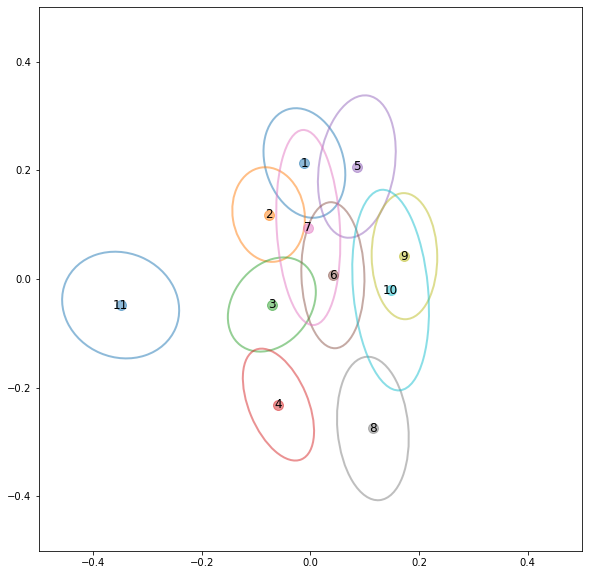

Iterating through the data set...
Iteration: 1 Delta: 0.06204384107383976


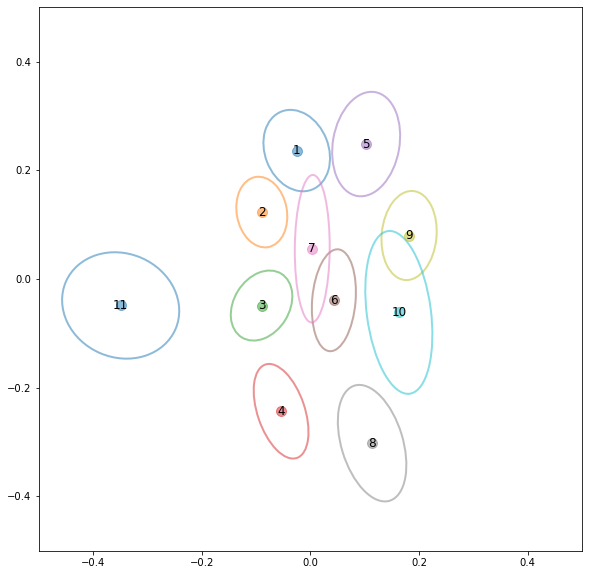

Iterating through the data set...
Iteration: 2 Delta: 0.00904210469147728


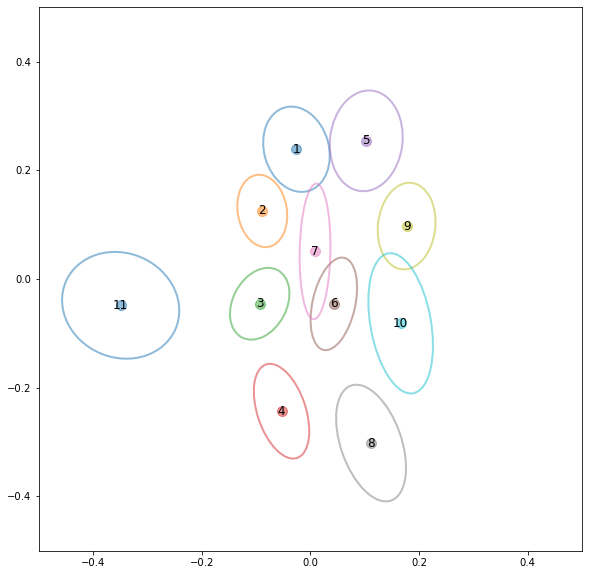

Iterating through the data set...
Iteration: 3 Delta: 0.003688151640302222


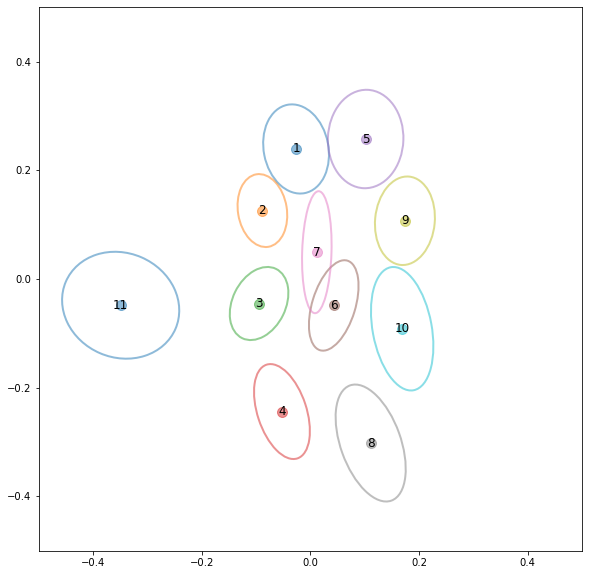

Iterating through the data set...
Iteration: 4 Delta: 0.0013111083112748237


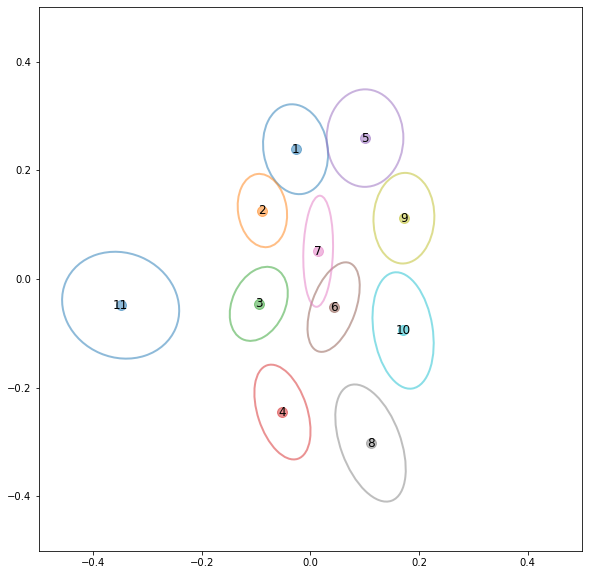

Iterating through the data set...
Iteration: 5 Delta: 0.000900408145616067


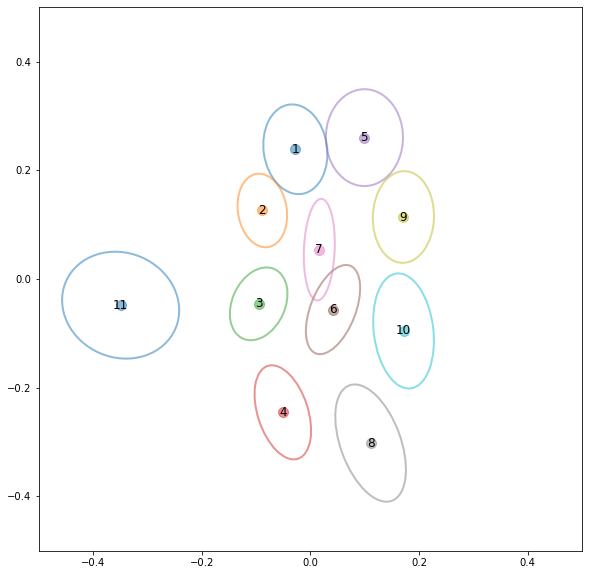

Iterating through the data set...
Iteration: 6 Delta: 0.002046912674473331


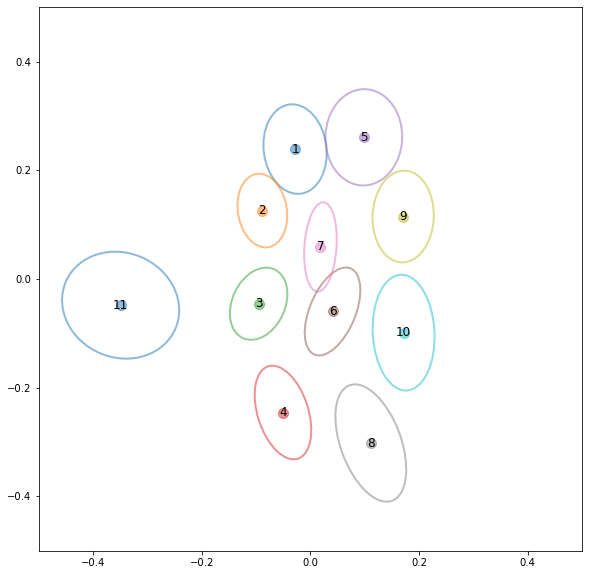

Iterating through the data set...
Iteration: 7 Delta: 0.0003804139721919909


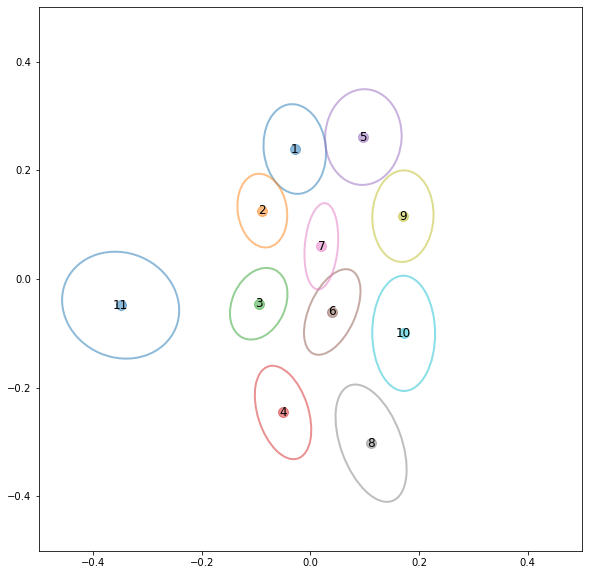

Iterating through the data set...
Iteration: 8 Delta: 0.0003322461404653943


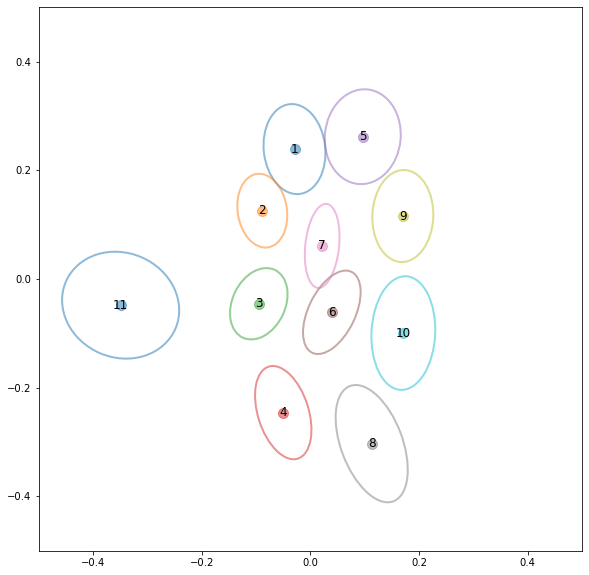

Iterating through the data set...
Iteration: 9 Delta: 0.0002675862605130911


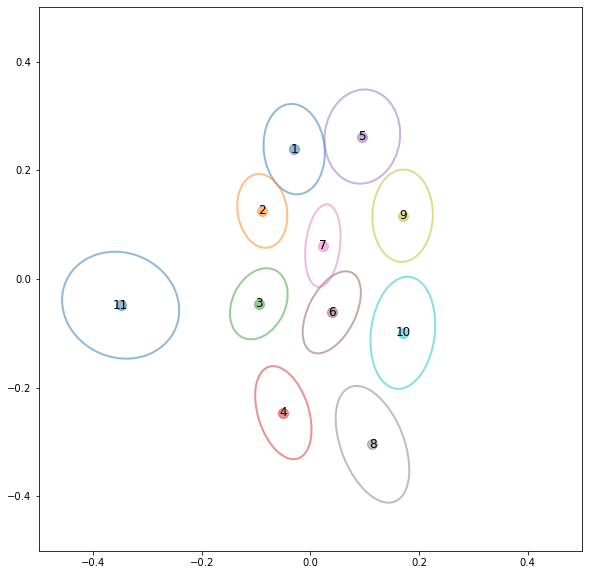

Iterating through the data set...
Iteration: 10 Delta: 0.00029732368101204596


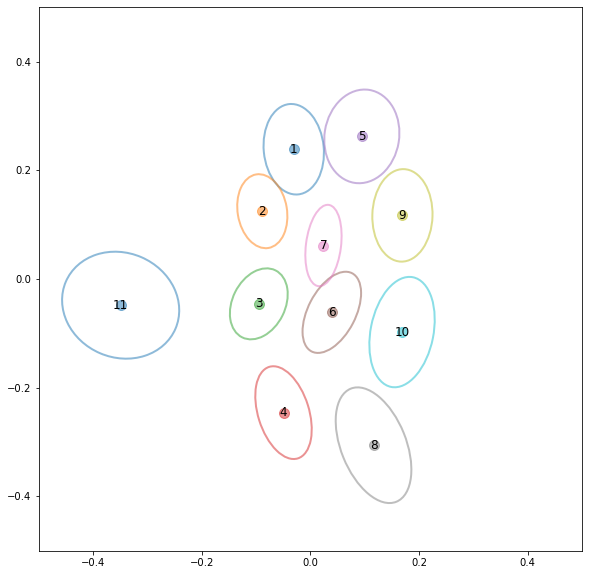

Iterating through the data set...
Iteration: 11 Delta: 0.00010251265582225536


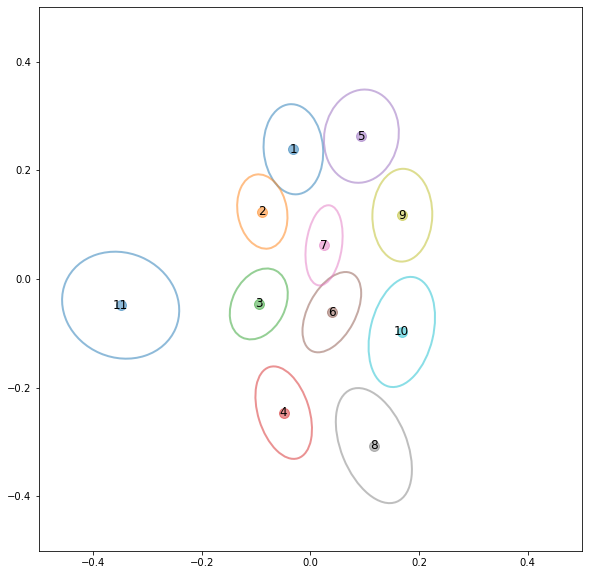

Iterating through the data set...
Iteration: 12 Delta: 7.826409975961858e-05


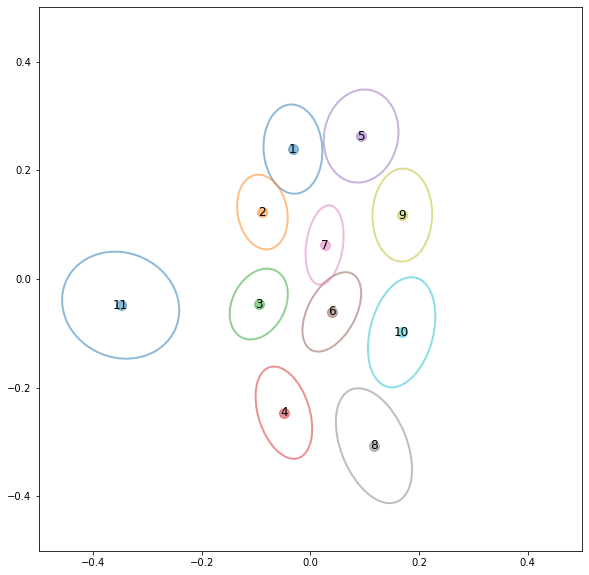

In [9]:
main_data_for_new_pdfs, main_formation = home.expectation_maximization(norm_home_player_positions, num_roles, num_players, entropy_method_threshold)

### Plot a single player's continuous pdf along with their discrete data

(0.0, 0.45)

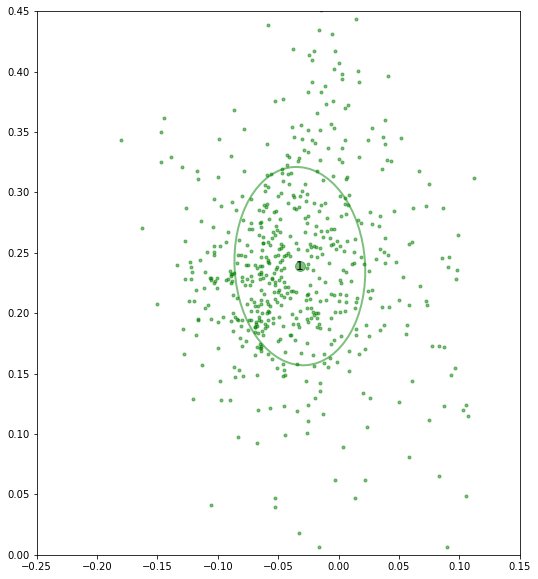

In [10]:
# Set up the figure
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_aspect('equal')



# Grab data from 1st player
matched_coords = main_data_for_new_pdfs['Role 1']
 
# individual_template = np.zeros((1, 2))
# individual_cluster_covs = np.zeros((1, 2, 2))

# Convert matched_coords to a NumPy array
matched_coords = np.array(matched_coords)
# Compute the centroid of the matched coordinates
mean = matched_coords.mean(axis=0)
x, y = mean

# Compute the covariance matrix of the matched coordinates
cov = np.cov(matched_coords, rowvar=False)

# Get the eigenvalues and eigenvectors of the covariance matrix
eigenvalues, eigenvectors = np.linalg.eigh(cov)
              

ax.plot(x, y, 'o', markersize=10, alpha=0.5, label=f'Player 1', color="green")

# Plot the Gaussian as an ellipse
ellipse = Ellipse(xy=mean, width=2*np.sqrt(eigenvalues[0]), height=2*np.sqrt(eigenvalues[1]), 
              angle=np.degrees(np.arctan2(*eigenvectors[:, 0][::-1])), edgecolor='green', lw=2, fill=False, alpha=0.5)
ax.add_artist(ellipse)

# Plot the player number at the centroid of the ellipse
ax.annotate(str(1), xy=mean, ha='center', va='center', fontsize=12)

# Scatter plot of individual data points
ax.scatter(matched_coords[::125, 0], matched_coords[::125, 1], marker='.', color="green", alpha=0.5)

# Set the axis limits and add a legend
ax.set_xlim([-0.25, 0.15])
ax.set_ylim([0, 0.45])



# Analysis III.a Short duration team formations (Home vs Away)

Initial Formation


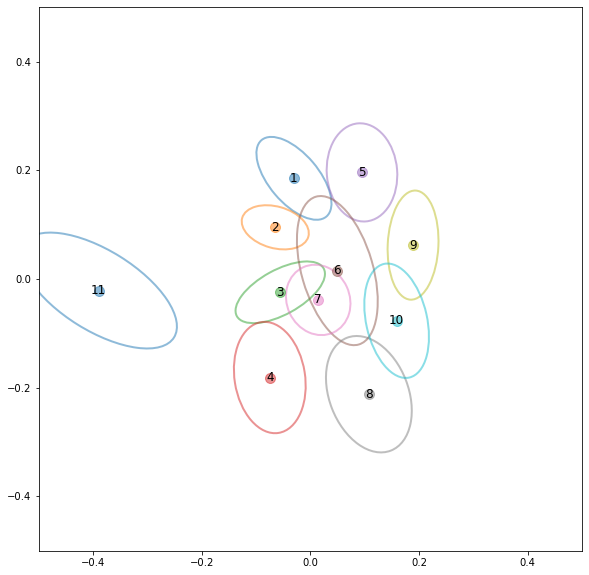

Iterating through the data set...
Iteration: 1 Delta: 0.04287281190267249


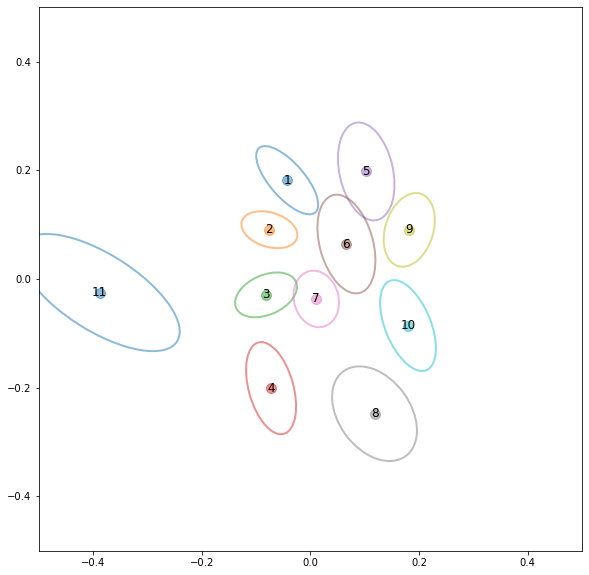

Iterating through the data set...
Iteration: 2 Delta: 0.002873685427088146


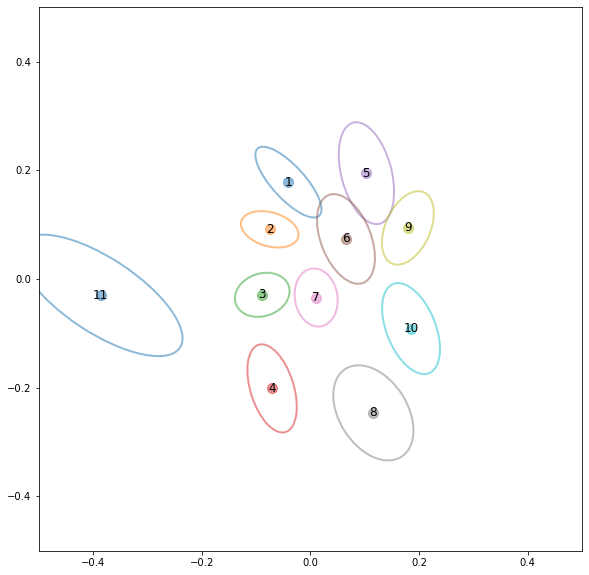

Iterating through the data set...
Iteration: 3 Delta: 0.0017150174889641915


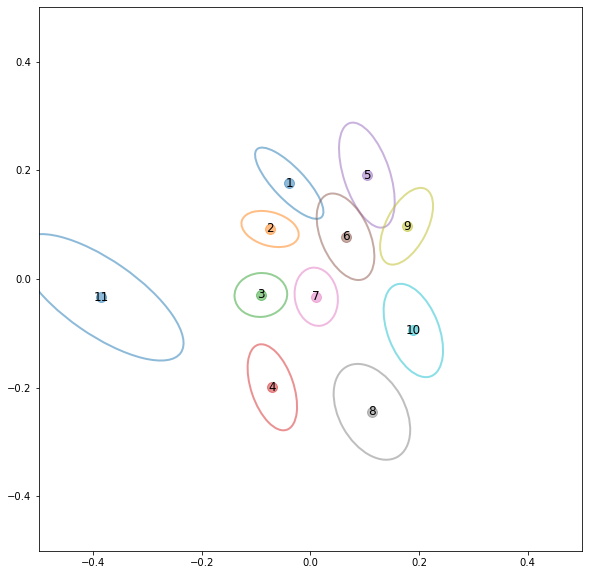

Iterating through the data set...
Iteration: 4 Delta: 0.0006476626734192355


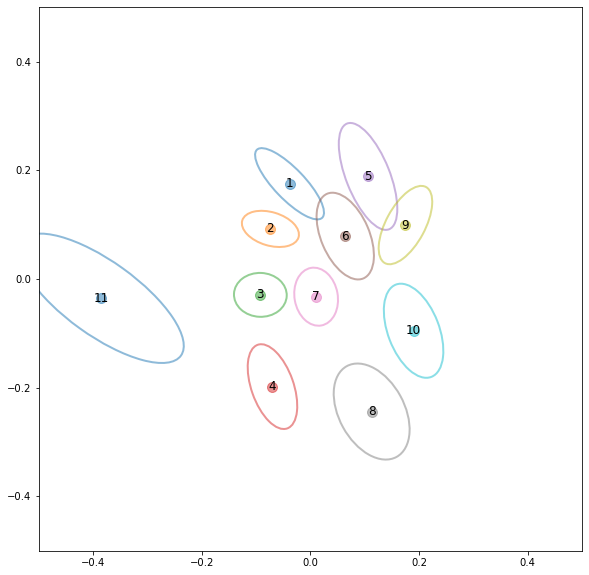

Iterating through the data set...
Iteration: 5 Delta: 5.222118322868897e-05


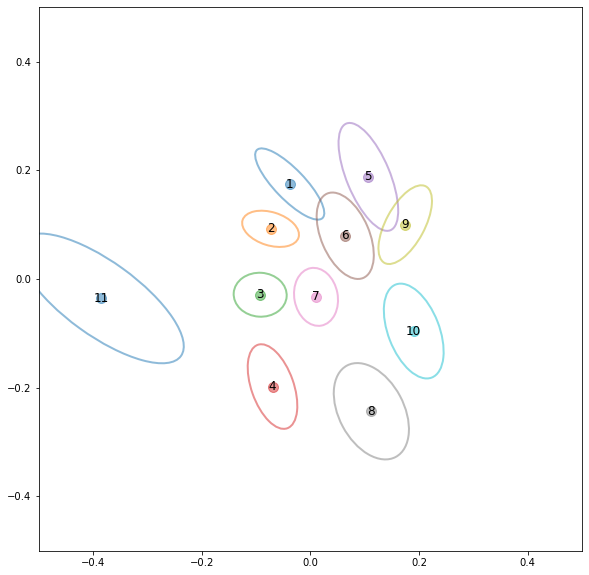

Initial Formation


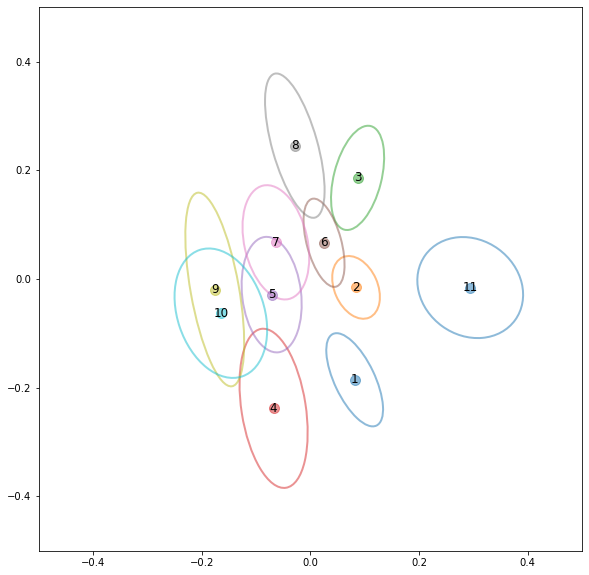

Iterating through the data set...
Iteration: 1 Delta: 0.02946921191257821


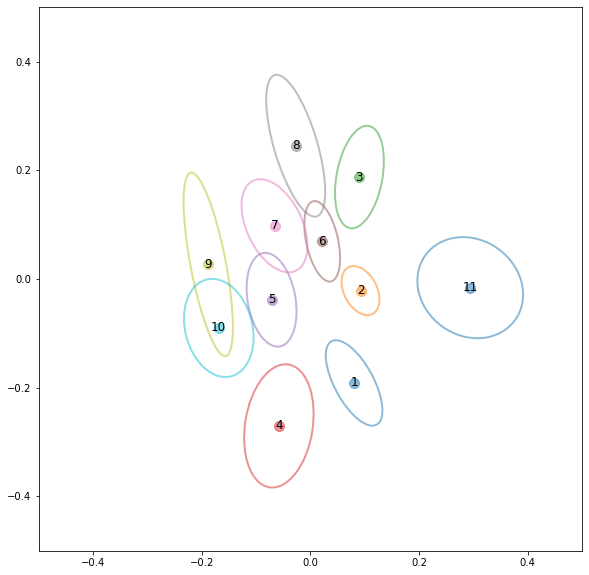

Iterating through the data set...
Iteration: 2 Delta: 0.004919435599986753


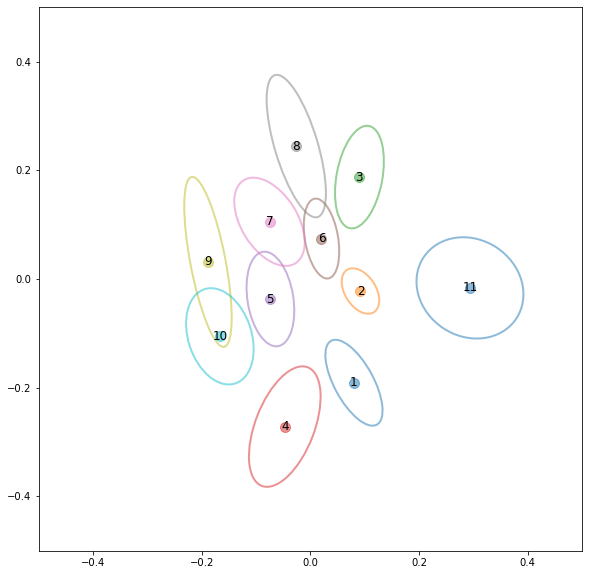

Iterating through the data set...
Iteration: 3 Delta: 0.0017389645880743446


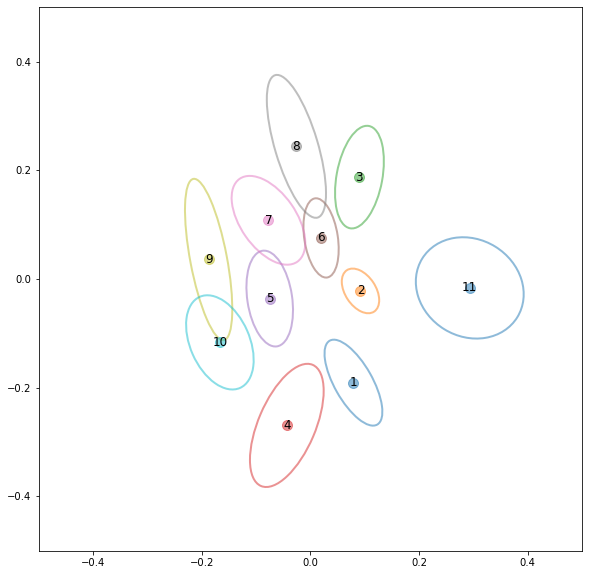

Iterating through the data set...
Iteration: 4 Delta: 0.0012510395591592495


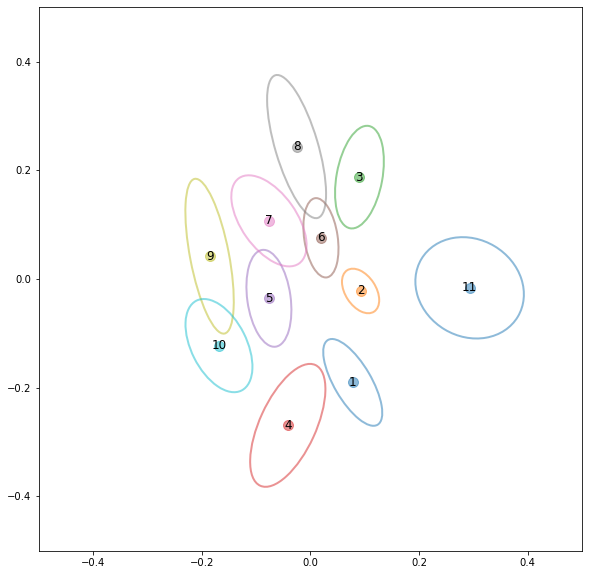

Iterating through the data set...
Iteration: 5 Delta: 0.00018841581210482066


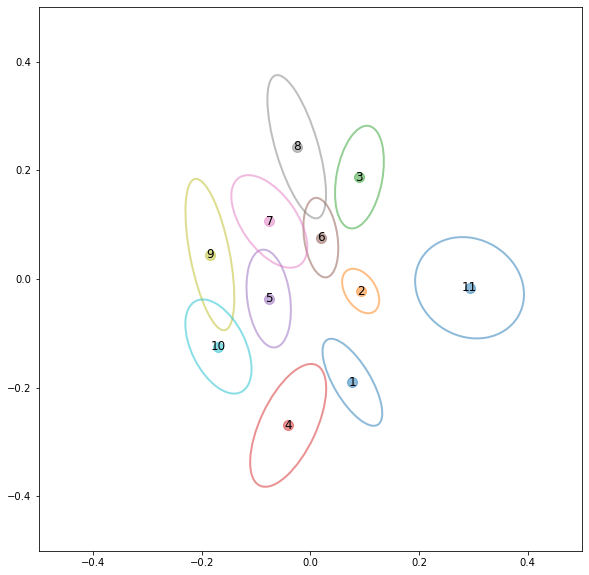

Iterating through the data set...
Iteration: 6 Delta: 3.454829447870302e-05


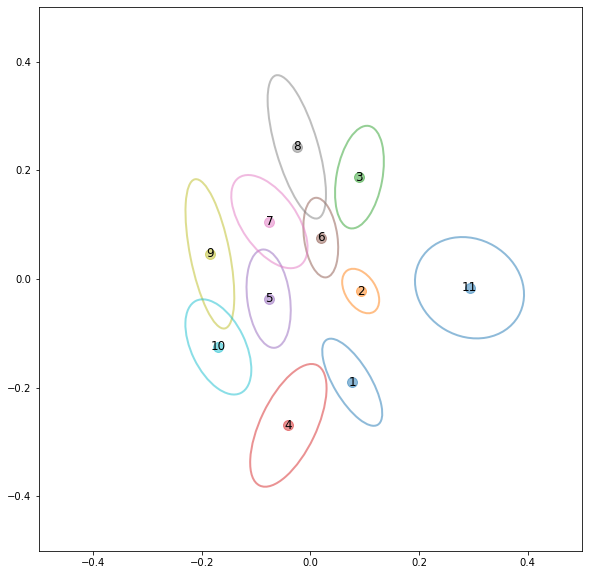

5-min Interval: 1


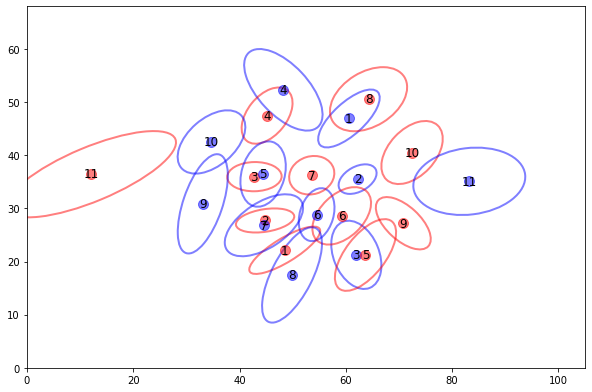

Initial Formation


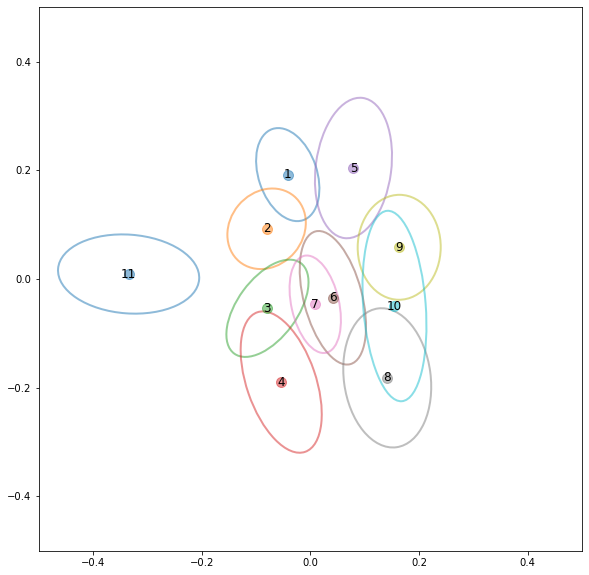

Iterating through the data set...
Iteration: 1 Delta: 0.07204001398096781


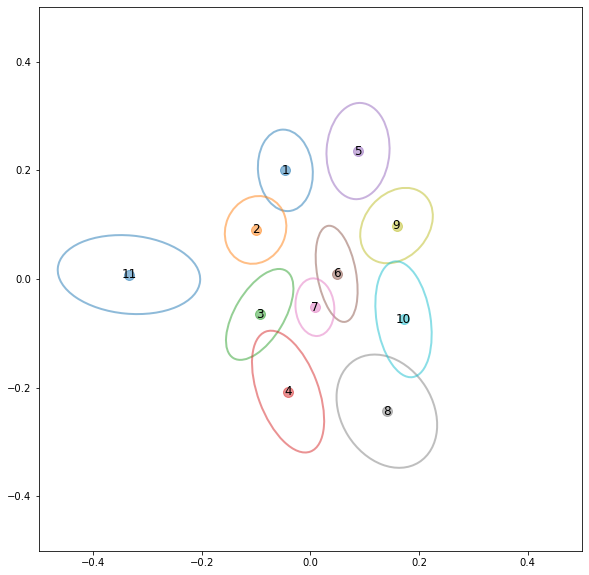

Iterating through the data set...
Iteration: 2 Delta: 0.008901851062720019


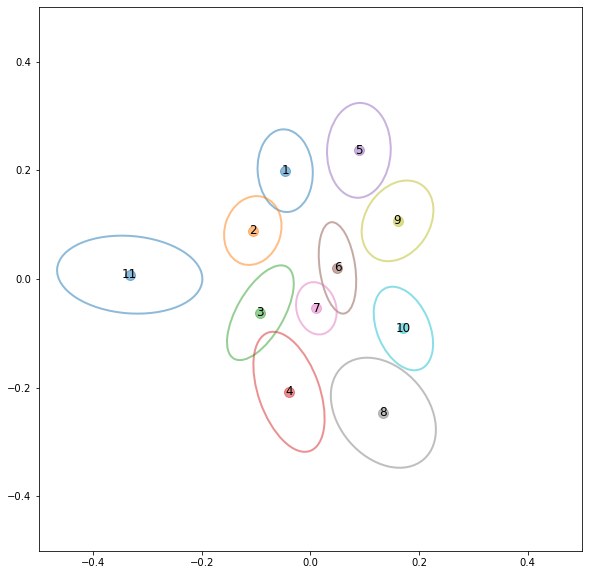

Iterating through the data set...
Iteration: 3 Delta: 0.0019457802329641708


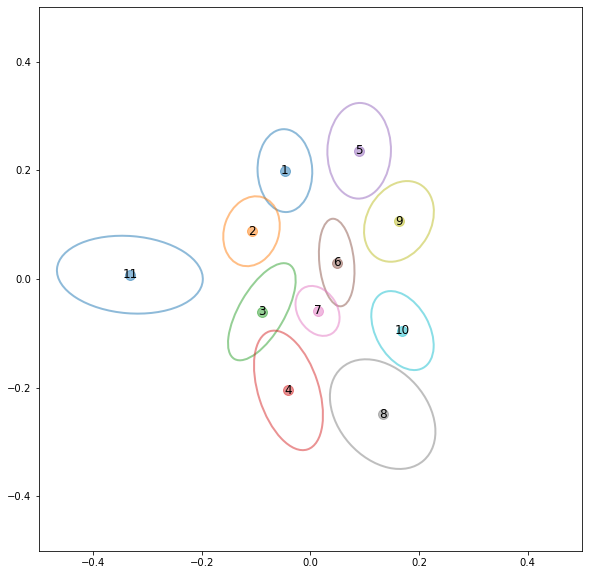

Iterating through the data set...
Iteration: 4 Delta: 0.0013688361610092559


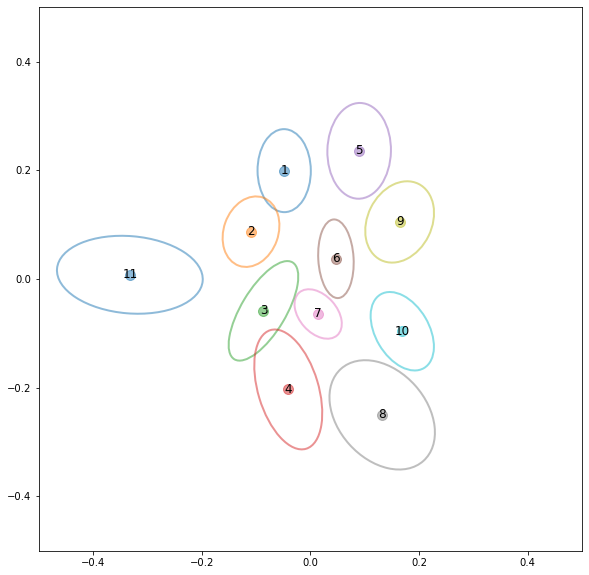

Iterating through the data set...
Iteration: 5 Delta: 0.003888156724463317


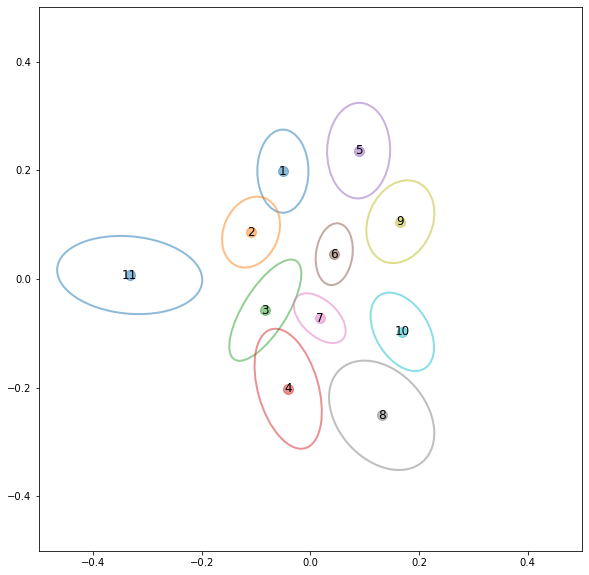

Iterating through the data set...
Iteration: 6 Delta: 0.0015698843583508667


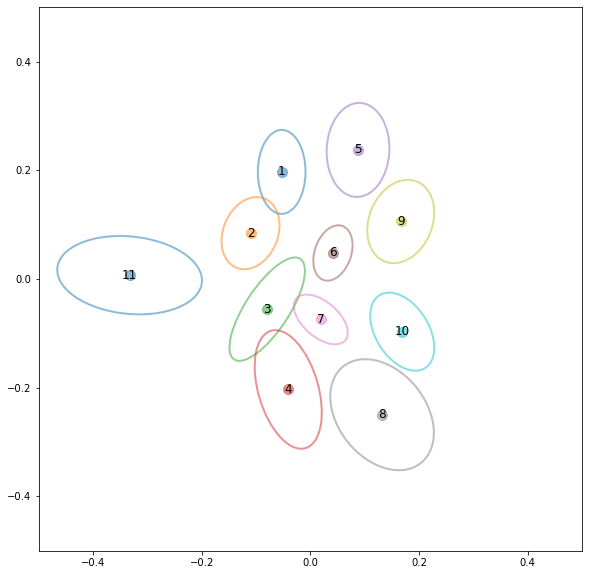

Iterating through the data set...
Iteration: 7 Delta: 0.0001330180855315026


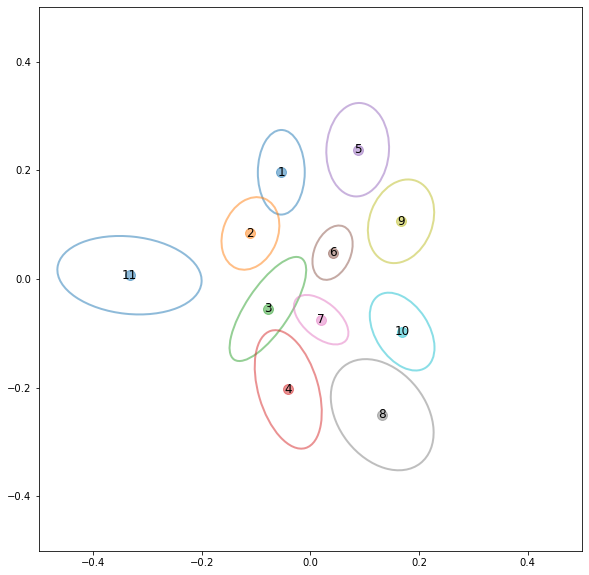

Iterating through the data set...
Iteration: 8 Delta: 1.491092136004773e-05


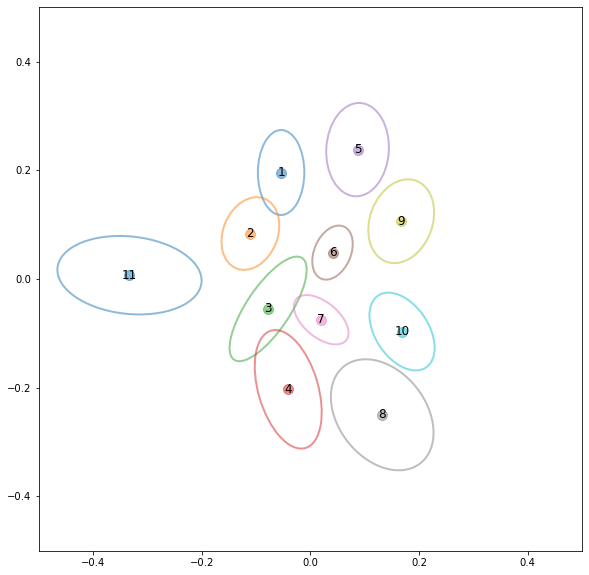

Initial Formation


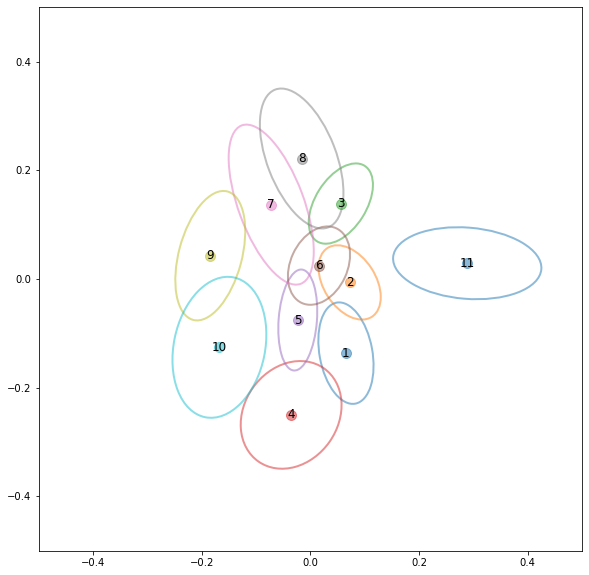

Iterating through the data set...
Iteration: 1 Delta: 0.05107104101621595


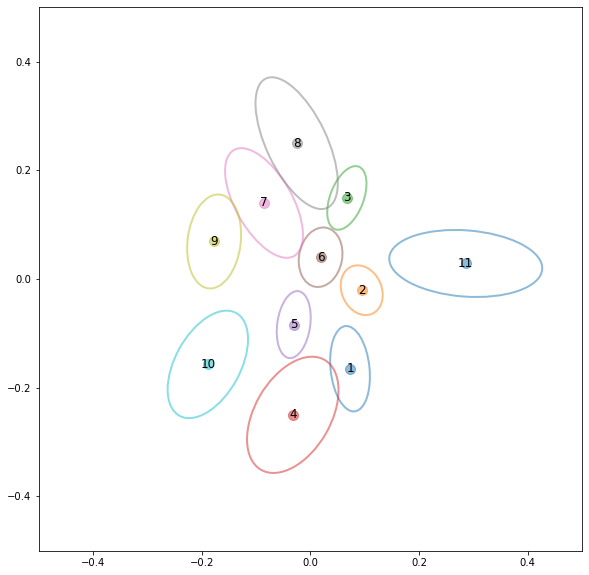

Iterating through the data set...
Iteration: 2 Delta: 0.003420078413830616


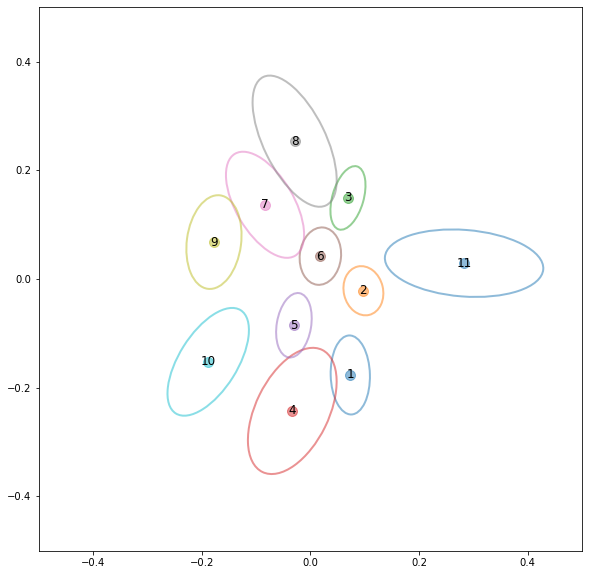

Iterating through the data set...
Iteration: 3 Delta: 0.0008042166141820417


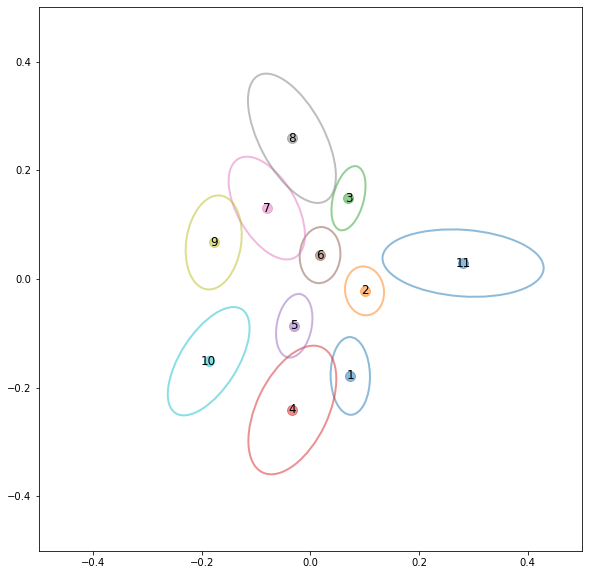

Iterating through the data set...
Iteration: 4 Delta: 0.00017000310164725355


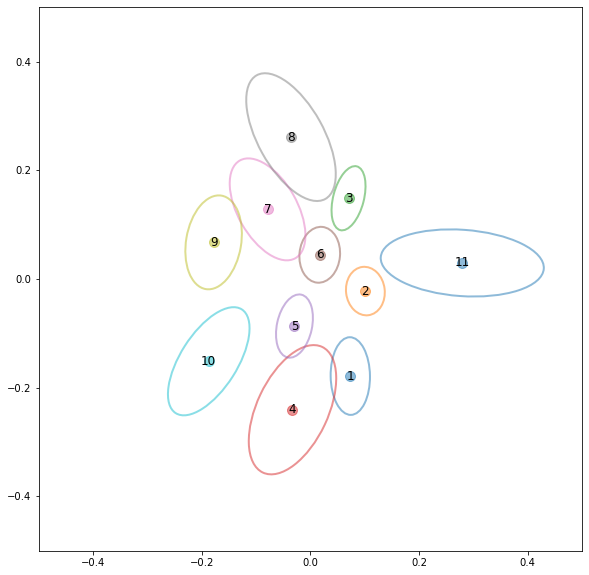

Iterating through the data set...
Iteration: 5 Delta: 3.770484788155933e-05


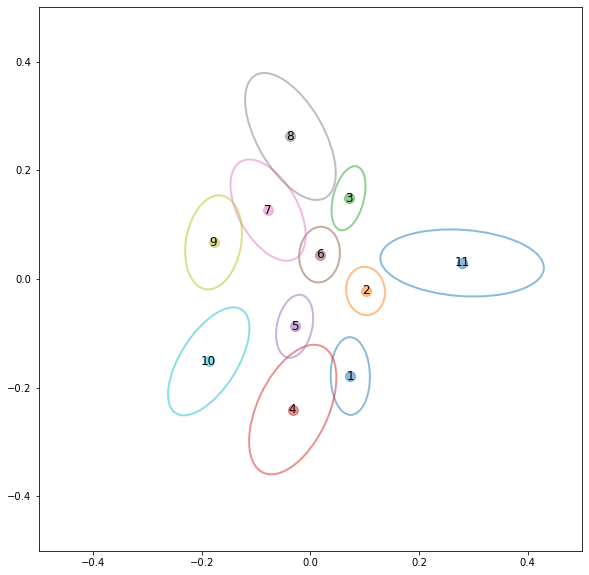

5-min Interval: 2


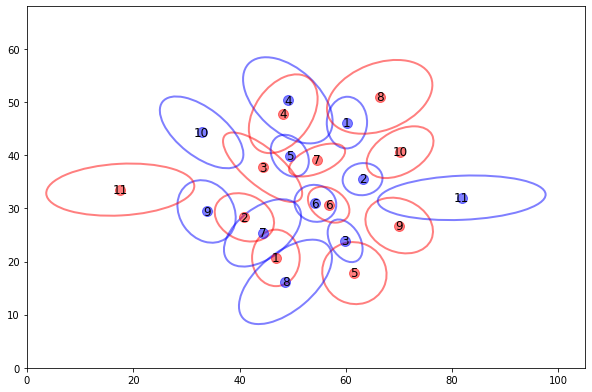

In [10]:
#max_intervals = norm_interval_home_player_positions.shape[0]
#for interval in range(max_intervals):
for interval in range(2):
    home_data = norm_interval_home_player_positions[interval] # select the player position data for only this interval
    away_data = norm_interval_away_player_positions[interval]
    
    home_pdf_data, home_formation = home.expectation_maximization(home_data, num_roles, num_players, entropy_method_threshold)
    away_pdf_data, away_formation = away.expectation_maximization(away_data, num_roles, num_players, entropy_method_threshold)

     
    # Transform the [x,y] coordinate pairs from a range of 0 to 1 to the actual dimensions of a soccer field (105x68 meters)
    away_pdf_data = linear_transform(away_pdf_data)
    home_pdf_data = linear_transform(home_pdf_data)
    
    # Recompute probability density functions for each role with transformed data and plot
    transformed_templates_away, transformed_cluster_covs_away = away_formation.compute_mean_and_cov(num_roles, away_pdf_data)
    transformed_templates_home, transformed_cluster_covs_home = home_formation.compute_mean_and_cov(num_roles, home_pdf_data)

    print(f'5-min Interval: {interval+1}')
    away_formation.plot_clusters(transformed_templates_home, transformed_cluster_covs_home,
                                 template2=transformed_templates_away, cluster_covs2=transformed_cluster_covs_away,
                                 method='adversarial', norm = False)  

# Analysis III.b Classify Ball Events by role and player identity

In [11]:
'''The paper defines ball events as one of 43 possible events (e.g.
passes, shots, crosses, tackles etc.) Since our data only includes ball-x 
and ball-y coordinates, we identify a ball event for each frame by determining 

1) the subset of players who are wihtin a 0.011 radius of the ball. This radius was 
qualitatively determined to indicate contact with the ball and was defined to negate frames 
where the ball is simply in transit through open space (i.e., an ongoing pass)

2) the one player in this subset who is closest to the ball. This player is making contact with the ball'''

from scipy.spatial.distance import cdist

def determine_ball_events(unnormalized_ball_positions, unnormalized_player_positions, normalized_player_positions, threshold=0.011):
    ball_events = np.zeros(unnormalized_ball_positions.shape)
    for frame, ball_position in enumerate(unnormalized_ball_positions):
        if (ball_position == [0.0, 0.0]).all(): 
            # We skip the frames where the ball's position is not tracked (i.e., out of bounds)
            ball_events[frame] = [None, None]
            
        else:
            # Compute distances between ball position and all player positions
            '''The ball's position cannot be normalized in the same way as the player's positions
            so we used unnormalized coordinates to evaluate pair wise distances between ball and 
            players'''
            distances = cdist([ball_position], unnormalized_player_positions[frame])
            # Filter player positions below threshold
            below_threshold = normalized_player_positions[frame][distances[0] <= threshold]

            # Select player position with minimum distance
            if below_threshold.size > 0:
                idx = np.argmin(distances[0][distances[0] <= threshold])
                normalized_player_position = below_threshold[idx]
            else:
                # If no player positions below threshold, append [NaN, NaN] for this frame
                normalized_player_position = [None, None]
        
            ball_events[frame] = normalized_player_position
            
    return ball_events



home_ball_events = determine_ball_events(home_unnormalized_ball_positions, home_unnormalized_player_positions, norm_home_player_positions)
away_ball_events = determine_ball_events(away_unnormalized_ball_positions, away_unnormalized_player_positions, norm_away_player_positions)

In [101]:
def plot_ball_events_by_role(ball_events, pdf_data):
    # Create a dictionary to store the colors corresponding to each key
    color_dict = {"Role 1": 'green', "Role 2": 'cyan', "Role 3": 'orange', "Role 4": 'blue', "Role 5": 'purple', 
                  "Role 6": 'red', "Role 7": 'black', "Role 8": 'pink', "Role 9": 'olive', "Role 10": 'lawngreen', 
                  "Role 11": 'lightcoral'}
    
    # Create a dictionary to store the x and y coordinates for each key
    coords_dict = {role: [] for role in pdf_data}

    
    # Iterate through the ball_events array
    print("Looping through the ball events data...")
    for i in tqdm(range(len(ball_events))):
        if not np.isnan(ball_events[i][0]):
            # Check if the [x, y] coordinates in ball_events match any of the keys in pdf_data
            for role, coord_list in pdf_data.items():
                if list(ball_events[i]) in coord_list:
                    # Store the x and y coordinates for the current key
                    coords_dict[role].append(ball_events[i])
                    break
    
    coords_dict = linear_transform(coords_dict)
    
    # Create a dictionary to store the colors corresponding to each key
    color_dict = {"Role 1": 'green', "Role 2": 'cyan', "Role 3": 'orange', "Role 4": 'blue', "Role 5": 'purple', 
                  "Role 6": 'red', "Role 7": 'black', "Role 8": 'pink', "Role 9": 'olive', "Role 10": 'lawngreen', 
                  "Role 11": 'lightcoral'}

    # Iterate over the keys in pdf_data and plot the corresponding scatter plot
    for i, role in enumerate(coords_dict):
        fig, ax = plt.subplots()
        ax.set_xlim([0, 105])
        ax.set_ylim([0, 68])
        x_coords, y_coords = zip(*coords_dict[role])
        ax.scatter(x_coords, y_coords, color=color_dict[role])
        ax.set_title(role)

        plt.show()
        # Save the plot to a file
        fig.savefig(f"IMAGES/{role}.png", dpi=300)
        plt.close(fig)  # Close the figure to free memory

Looping through the data...


100%|███████████████████████████████████████████████████████████████████████████| 71268/71268 [05:45<00:00, 206.36it/s]


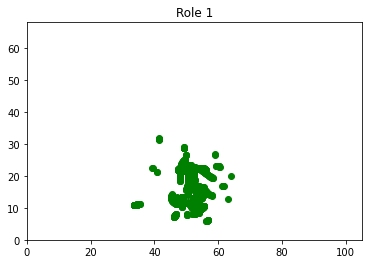

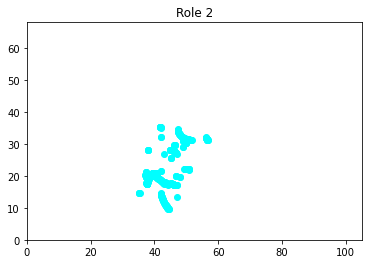

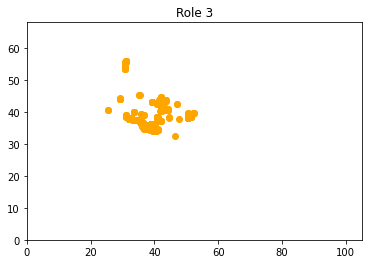

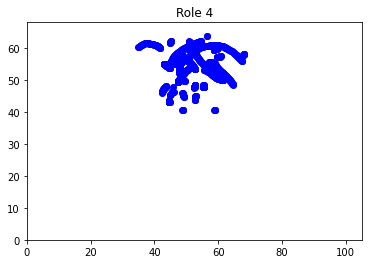

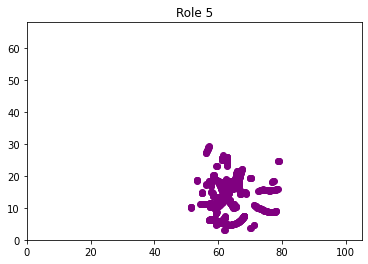

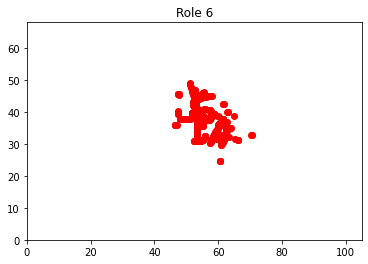

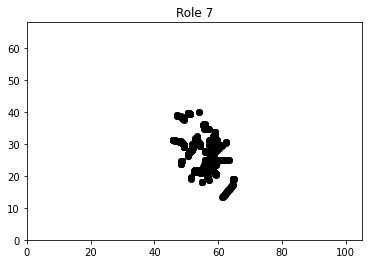

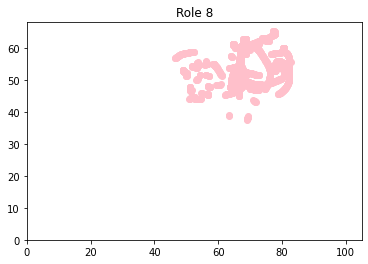

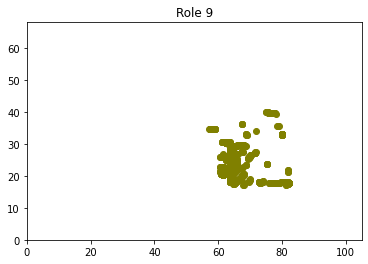

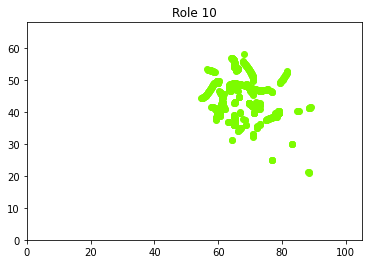

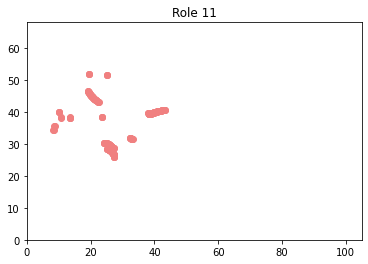

In [102]:
plot_ball_events_by_role(home_ball_events, main_data_for_new_pdfs)

In [106]:
def plot_ball_events_by_playerID(ball_events, normalized_player_positions, pdf_data):

    # Create a dictionary to store the colors corresponding to each role
    color_dict = {"Role 1": 'green', "Role 2": 'cyan', "Role 3": 'orange', "Role 4": 'blue', "Role 5": 'purple', 
                  "Role 6": 'red', "Role 7": 'black', "Role 8": 'pink', "Role 9": 'olive', "Role 10": 'lawngreen', 
                  "Role 11": 'lightcoral'}
    
    # Create a dictionary to store the x and y coordinates for each player
    coords_dict = {str(player+1): [] for player in range(14)}
    roles_dict = {str(player+1): [] for player in range(14)}
    
    # Iterate through the ball_events array
    print("Looping through the ball events data...")
    for i in tqdm(range(len(ball_events))):
        if not np.isnan(ball_events[i][0]):
            # Identify the player identity for the [x,y] coordinate
            player_idx = np.where((normalized_player_positions[i] == ball_events[i]).all(axis=1))[0]
            player = str(int(player_idx+1))
            coords_dict[player].append(ball_events[i])
            
            # Identify the player role for the [x,y] coordinate
            for role, coord_list in pdf_data.items():
                if list(ball_events[i]) in coord_list:
                    # Store the role for the current [x,y] pair
                    roles_dict[player].append(role)
                    break
 
                 
    coords_dict = linear_transform(coords_dict)
    
    # Iterate over the keys in pdf_data and plot the corresponding scatter plot
    for i, player in enumerate(coords_dict):
        if len(coords_dict[player]) == 0:
            continue
            
        fig, ax = plt.subplots()
        ax.set_xlim([0, 105])
        ax.set_ylim([0, 68])
        
        x_coords, y_coords= zip(*coords_dict[player])
        roles = roles_dict[player]
        
        index = 0
        for role in roles:
            ax.scatter(x_coords[index], y_coords[index], color=color_dict[role])
            index+=1
            
        ax.set_title(f"Player {player}")
        plt.show()
        
        # Save the plot to a file
        fig.savefig(f"IMAGES/Player_{player}.png", dpi=300)
        plt.close(fig)  # Close the figure to free memory
    
    return coords_dict, roles_dict

Looping through the ball events data...


100%|███████████████████████████████████████████████████████████████████████████| 71268/71268 [05:40<00:00, 209.24it/s]


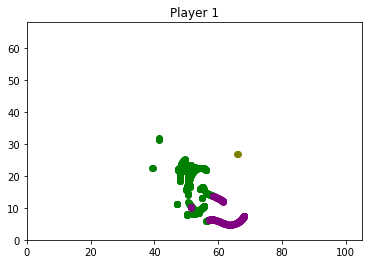

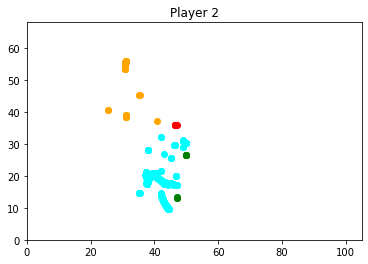

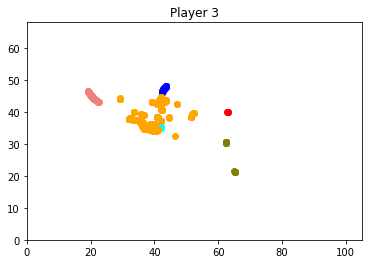

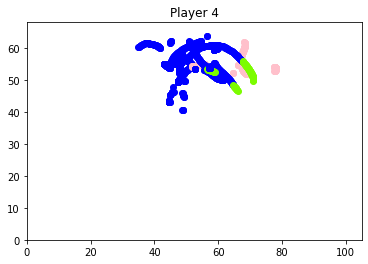

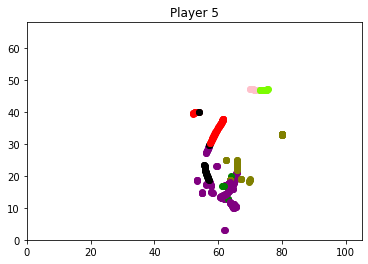

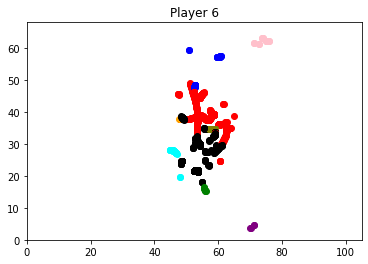

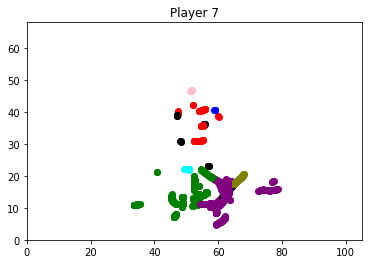

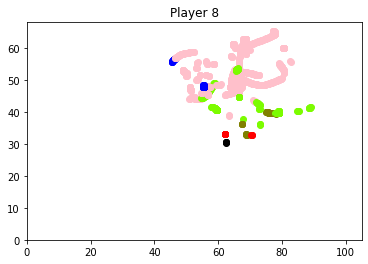

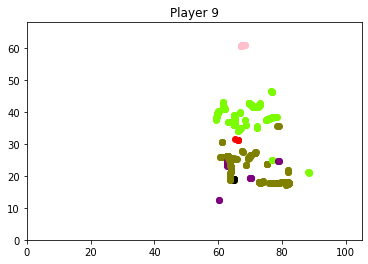

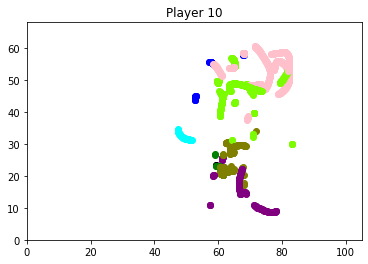

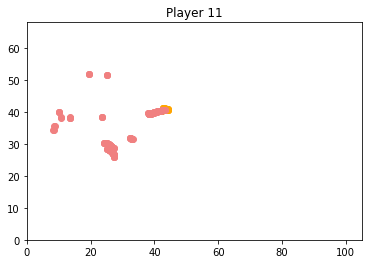

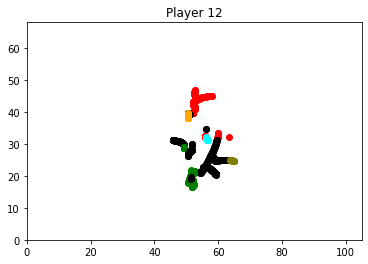

In [108]:
coords_dict,roles_dict = plot_ball_events_by_playerID(home_ball_events, norm_home_player_positions, main_data_for_new_pdfs)

# Analysis III.c Dynamic Interchanging of Player Positions

In [10]:
def plot_player_interchange(normalized_player_positions, pdf_data):
    # Create a dictionary to store the x and y coordinates for each player
    roles_dict = {player+1: [None]*normalized_player_positions.shape[0] for player in range(14)}
    
    # Convert pdf_data to a 2D numpy array for faster processing
    pdf_data_arr = np.concatenate(list(pdf_data.values()))
    
    # Iterate through the ball_events array
    print("Looping through the data...")
    for frame, player_positions in tqdm(enumerate(normalized_player_positions)):
        # Identify the player role for the [x,y] coordinate        
        mask = np.all(player_positions[:, None, :] == pdf_data_arr, axis=2)
        index_array = np.argmax(mask, axis=1) // normalized_player_positions.shape[0] # Convert back to the first index value of pdf_data
        
        # We only add 1 to indices of index_array where the player_position at that index is non-zero
        mask = ~(player_positions == 0).any(axis=1)
        index_array[mask] += 1
        
        for player, role in enumerate(index_array):
            if role != 0:                
                roles_dict[player+1][frame] = f"Role {role}"
    
    return roles_dict


In [11]:
'''roles_dict contains information about what role every player is assigned to at every frame of the game'''
roles_dict = plot_player_interchange(norm_home_player_positions, main_data_for_new_pdfs)

Looping through the data...


71268it [3:54:06,  5.07it/s]


FileNotFoundError: [Errno 2] No such file or directory: 'DATA/roles_dict.json'

In [40]:
np.unique(roles_dict[10])

array(['Role 1', 'Role 10', 'Role 2', 'Role 3', 'Role 4', 'Role 5',
       'Role 6', 'Role 7', 'Role 8', 'Role 9'], dtype='<U7')

In [45]:
roles_dict.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])

In [26]:
# Open a file for writing
with open("DATA/roles_dict.json", "w") as outfile:
    # Write the dictionary to the file in JSON format
    json.dump(roles_dict , outfile)

In [42]:
def plot_roles_dict(roles_dict):
    # Create a dictionary to store the colors corresponding to each role
    color_dict = {"Role 1": 'green', "Role 2": 'cyan', "Role 3": 'orange', "Role 4": 'blue', "Role 5": 'purple', 
                  "Role 6": 'red', "Role 7": 'black', "Role 8": 'pink', "Role 9": 'olive', "Role 10": 'lawngreen', 
                  "Role 11": 'lightcoral'}
    
    # Define the y-data 
    y_data = list(roles_dict.keys())

    # Define the x-data
    num_frames = len(roles_dict[1])
    x_data = range(num_frames+1)

    # Create the figure and axes objects
    fig, ax = plt.subplots(figsize=(8, 6))

    # Loop over each y-value to create a horizontal bar
    for y in y_data:
        # Get the roles for the current y-value 
        roles = roles_dict[y]

        for x in tqdm(x_data[:-1]):
          # Get the color for the current role at the current frame
          color = color_dict.get(roles[x], 'white')
          # Plot a horizontal bar for the current frame with the current color
          ax.barh(y=y-1, width=num_frames, left=x, color=color, height=1, align='center')

    # Set the y-tick labels 
    y_tick_labels = [str(y) for y in y_data]
    ax.set_yticks(range(len(y_data)))
    ax.set_yticklabels(y_tick_labels)
    
    # Set the x-tick labels
    x_tick_labels = [str(i/10000) for i in range(0, num_frames+1, 5000)]
    ax.set_xticks(range(0, num_frames+1, 5000))    
    ax.set_xticklabels(x_tick_labels)

    # Set the title and axis labels
    ax.set_xlabel('Frame Number x10\N{SUPERSCRIPT FOUR}')
    ax.set_ylabel('PlayerIdx')
    ax.set_ylim(-0.5,13.5)
    ax.set_xlim(0,num_frames)
    ax.invert_yaxis()

    # Show the plot
    plt.show()

100%|██████████████████████████████████████████████████████████████████████████| 71268/71268 [00:41<00:00, 1721.24it/s]


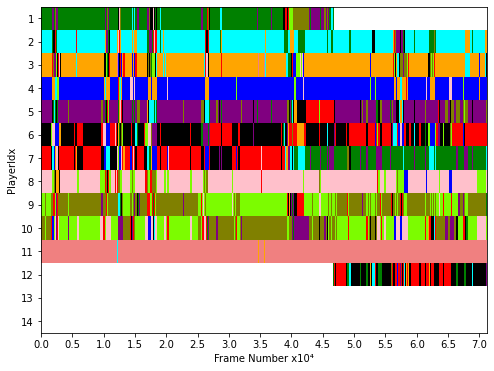

In [43]:
plot_roles_dict(roles_dict)

In [80]:
adj_matrix = {f'Role {i}' : {f'Role {j}':0 for j in range(1,12)} for i in range(1,12) }

# Loop over each list and extract the dominant role
for i, lst in enumerate(roles_dict.values()):
    # Remove None values from the list if any
    lst = [x for x in lst if x is not None]
    
    # Get the dominant role if list is not empty
    if lst:
        dominant_role = statistics.mode(lst)

        # Count the frequency of each other role in the list
        for role in lst:
            if role != dominant_role:
                adj_matrix[dominant_role][role] += 1
                
# Find the maximum and minimum values in the matrix
max_val = max([max(values.values()) for values in adj_matrix.values()])
min_val = min([min(values.values()) for values in adj_matrix.values()])

# Normalize each value in the matrix using (value - min)/(max - min)
for key, values in adj_matrix.items():
    for role, freq in values.items():
        adj_matrix[key][role] = (freq - min_val) / (max_val - min_val)


print(adj_matrix)

{'Role 1': {'Role 1': 0.0, 'Role 2': 0.05341737385119194, 'Role 3': 0.0020775379414768127, 'Role 4': 0.0, 'Role 5': 0.15824500862706434, 'Role 6': 0.03619845769217226, 'Role 7': 0.04721997253424416, 'Role 8': 0.007535476601288778, 'Role 9': 0.12310292615937181, 'Role 10': 0.030740519032360296, 'Role 11': 0.0}, 'Role 2': {'Role 1': 0.1885981900771154, 'Role 2': 0.0, 'Role 3': 0.12806788971442656, 'Role 4': 0.006619951406739674, 'Role 5': 0.05074122328250995, 'Role 6': 0.03366315715342089, 'Role 7': 0.06524877636536498, 'Role 8': 0.013768090425719215, 'Role 9': 0.015458290784886792, 'Role 10': 0.0013028627768583401, 'Role 11': 0.0044719884502975454}, 'Role 3': {'Role 1': 0.01577520335223071, 'Role 2': 0.09366526990386985, 'Role 3': 0.0, 'Role 4': 0.05450896158315434, 'Role 5': 0.0273953308215078, 'Role 6': 0.08271418007676326, 'Role 7': 0.09436952005352302, 'Role 8': 0.03158561921194408, 'Role 9': 0.05936828761576112, 'Role 10': 0.07412232825099475, 'Role 11': 0.01757104123384626}, 'Role

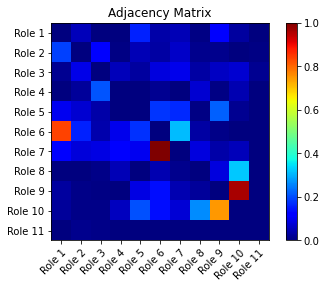

In [82]:
import matplotlib.pyplot as plt
import numpy as np


# Create an 11x11 matrix of zeros
matrix = np.zeros((11,11))

# Iterate over the keys of the adjacency matrix dictionary
for i, key in enumerate(adj_matrix.keys()):
    # Iterate over the values of the key
    for j, value in enumerate(adj_matrix[key].values()):
        # Set the value in the matrix
        matrix[i][j] = value        
        
# Define the color map
cmap = plt.cm.get_cmap('jet')

# Create the figure and axis objects
fig, ax = plt.subplots()

# Create the heatmap
heatmap = ax.imshow(matrix, cmap=cmap)

# Add a color bar
cbar = plt.colorbar(heatmap)

# Set the tick marks and labels for the x-axis
ax.set_xticks(np.arange(11))
ax.set_xticklabels(list(adj_matrix.keys()))

# Set the tick marks and labels for the y-axis
ax.set_yticks(np.arange(11))
ax.set_yticklabels(list(adj_matrix.keys()))

# Rotate the x-axis tick labels
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Set the title of the plot
ax.set_title("Adjacency Matrix")

# Show the plot
plt.show()
